In [3]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("praneet0327/brain-tumor-dataset")
print("Dataset downloaded to:", path)


100%|██████████| 100M/100M [00:05<00:00, 17.7MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1


In [4]:
!ls -R /root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1


/root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1:
Brain_Tumor_Dataset

/root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1/Brain_Tumor_Dataset:
Negative  Positive

/root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1/Brain_Tumor_Dataset/Negative:
Te-no_0010.jpg	  Tr-no_0105.jpg  Tr-no_0605.jpg  Tr-no_1105.jpg
Te-no_0011.jpg	  Tr-no_0106.jpg  Tr-no_0606.jpg  Tr-no_1106.jpg
Te-no_0012.jpg	  Tr-no_0107.jpg  Tr-no_0607.jpg  Tr-no_1107.jpg
Te-no_0013.jpg	  Tr-no_0108.jpg  Tr-no_0608.jpg  Tr-no_1108.jpg
Te-no_0014.jpg	  Tr-no_0109.jpg  Tr-no_0609.jpg  Tr-no_1109.jpg
Te-no_0015.jpg	  Tr-no_0110.jpg  Tr-no_0610.jpg  Tr-no_1110.jpg
Te-no_0016.jpg	  Tr-no_0111.jpg  Tr-no_0611.jpg  Tr-no_1111.jpg
Te-no_0017.jpg	  Tr-no_0112.jpg  Tr-no_0612.jpg  Tr-no_1112.jpg
Te-no_0018.jpg	  Tr-no_0113.jpg  Tr-no_0613.jpg  Tr-no_1113.jpg
Te-no_0019.jpg	  Tr-no_0114.jpg  Tr-no_0614.jpg  Tr-no_1114.jpg
Te-no_0020.jpg	  Tr-no_0115.jpg  Tr-no_061

In [5]:
import os, shutil, random

source_root = "/root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1/Brain_Tumor_Dataset"
classes = ["Negative", "Positive"]   # <--- your actual folder names

output_root = "data_split"
os.makedirs(output_root, exist_ok=True)

# create subfolders
for subset in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_root, subset, cls), exist_ok=True)

for cls in classes:
    src = os.path.join(source_root, cls)
    imgs = os.listdir(src)
    random.shuffle(imgs)

    n = len(imgs)
    train_end = int(0.7 * n)
    val_end = train_end + int(0.15 * n)

    print(f"{cls}: total={n}, train={train_end}, val={val_end-train_end}, test={n-val_end}")

    for i, img in enumerate(imgs):
        if i < train_end:
            subset = "train"
        elif i < val_end:
            subset = "val"
        else:
            subset = "test"

        shutil.copy(
            os.path.join(src, img),
            os.path.join(output_root, subset, cls, img)
        )

print("DONE SPLITTING!")


Negative: total=2000, train=1400, val=300, test=300
Positive: total=3266, train=2286, val=489, test=491
DONE SPLITTING!


In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===== DATA LOADERS =====

def get_dataloaders(data_root="data_split", batch_size=32, num_workers=2):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    train_dir = os.path.join(data_root, "train")
    val_dir   = os.path.join(data_root, "val")
    test_dir  = os.path.join(data_root, "test")

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
    test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                               num_workers=num_workers)

    class_names = train_dataset.classes  # e.g. ['no', 'yes']
    print("Classes:", class_names)

    return train_loader, val_loader, test_loader, class_names


# ===== MODEL =====

def get_resnet50_model(num_classes=1, pretrained=True):
    # pretrained=True works on most Colab PyTorch versions
    model = models.resnet50(pretrained=pretrained)

    # Freeze all layers first (feature extraction stage)
    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)  # 1 output for binary
    )
    return model


def unfreeze_last_layers(model):
    # Simple: unfreeze layer4 and fc for fine-tuning
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True


# ===== TRAIN / EVAL FUNCTIONS =====

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).float()  # BCEWithLogitsLoss wants float

        optimizer.zero_grad()

        outputs = model(images).squeeze(1)  # [batch]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    return epoch_loss, acc, f1, prec, rec, auc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    return epoch_loss, acc, f1, prec, rec, auc


# ===== MAIN TRAINING LOOP =====

def main():
    data_root = "data_split"     # change if your folder name is different
    batch_size = 32
    base_epochs = 10             # first stage: train head only
    finetune_epochs = 5          # second stage: fine-tune
    lr_head = 1e-3
    lr_finetune = 1e-4

    train_loader, val_loader, test_loader, class_names = get_dataloaders(
        data_root=data_root,
        batch_size=batch_size
    )

    model = get_resnet50_model(num_classes=1, pretrained=True)
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr_head
    )

    best_val_f1 = 0.0
    best_state_dict = None

    print("=== Stage 1: Train classifier head (backbone frozen) ===")
    for epoch in range(base_epochs):
        train_loss, train_acc, train_f1, train_prec, train_rec, train_auc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, val_f1, val_prec, val_rec, val_auc = evaluate(
            model, val_loader, criterion, device
        )

        print(f"Epoch {epoch+1}/{base_epochs}")
        print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.3f}, f1={train_f1:.3f}, auc={train_auc:.3f}")
        print(f"  Val  : loss={val_loss:.4f}, acc={val_acc:.3f}, f1={val_f1:.3f}, auc={val_auc:.3f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state_dict = model.state_dict()

    # ===== Fine-tuning stage =====
    print("\n=== Stage 2: Fine-tune last layers ===")
    unfreeze_last_layers(model)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr_finetune
    )

    for epoch in range(finetune_epochs):
        train_loss, train_acc, train_f1, train_prec, train_rec, train_auc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, val_f1, val_prec, val_rec, val_auc = evaluate(
            model, val_loader, criterion, device
        )

        print(f"[FT] Epoch {epoch+1}/{finetune_epochs}")
        print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.3f}, f1={train_f1:.3f}, auc={train_auc:.3f}")
        print(f"  Val  : loss={val_loss:.4f}, acc={val_acc:.3f}, f1={val_f1:.3f}, auc={val_auc:.3f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state_dict = model.state_dict()

    # Load best weights and evaluate on test set
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    test_loss, test_acc, test_f1, test_prec, test_rec, test_auc = evaluate(
        model, test_loader, criterion, device
    )

    print("\n=== TEST RESULTS ===")
    print(f"loss={test_loss:.4f}")
    print(f"acc ={test_acc:.3f}")
    print(f"f1  ={test_f1:.3f}")
    print(f"prec={test_prec:.3f}")
    print(f"rec ={test_rec:.3f}")
    print(f"auc ={test_auc:.3f}")

    torch.save(model.state_dict(), "brain_tumor_resnet50.pth")
    print("Saved model as brain_tumor_resnet50.pth")


# Actually run training
main()


Using device: cuda
Classes: ['Negative', 'Positive']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 69.9MB/s]


=== Stage 1: Train classifier head (backbone frozen) ===
Epoch 1/10
  Train: loss=0.3611, acc=0.864, f1=0.896, auc=0.933
  Val  : loss=0.2218, acc=0.930, f1=0.945, auc=0.981
Epoch 2/10
  Train: loss=0.2079, acc=0.931, f1=0.945, auc=0.976
  Val  : loss=0.1808, acc=0.935, f1=0.949, auc=0.983
Epoch 3/10
  Train: loss=0.1794, acc=0.937, f1=0.950, auc=0.982
  Val  : loss=0.1948, acc=0.925, f1=0.943, auc=0.983
Epoch 4/10
  Train: loss=0.1745, acc=0.939, f1=0.951, auc=0.981
  Val  : loss=0.1627, acc=0.939, f1=0.952, auc=0.987
Epoch 5/10
  Train: loss=0.1558, acc=0.944, f1=0.955, auc=0.984
  Val  : loss=0.1474, acc=0.948, f1=0.959, auc=0.988
Epoch 6/10
  Train: loss=0.1600, acc=0.942, f1=0.954, auc=0.983
  Val  : loss=0.1392, acc=0.948, f1=0.958, auc=0.988
Epoch 7/10
  Train: loss=0.1516, acc=0.946, f1=0.957, auc=0.985
  Val  : loss=0.1600, acc=0.944, f1=0.957, auc=0.988
Epoch 8/10
  Train: loss=0.1400, acc=0.951, f1=0.961, auc=0.987
  Val  : loss=0.1310, acc=0.952, f1=0.961, auc=0.990
Epoch 9

In [7]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


True
Tesla T4


CHECKING

Saving tumor.jpeg to tumor (1).jpeg


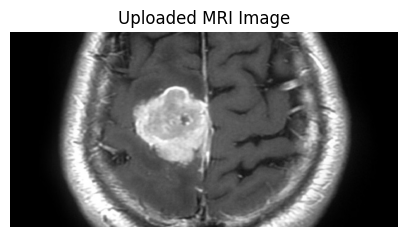

Tumor Probability     : 99.3767%
No Tumor Probability  : 0.6233%
Final Prediction      : Tumor


In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = get_resnet50_model(num_classes=1, pretrained=False)
model.load_state_dict(torch.load("brain_tumor_resnet50.pth", map_location=device))
model.to(device)
model.eval()

# Transform same as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def predict_image(img_path):
    # Load and show image
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded MRI Image")
    plt.show()

    # Preprocess
    tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(tensor).squeeze(1)
        prob = torch.sigmoid(output).item()

    tumor_prob = prob * 100
    no_tumor_prob = (1 - prob) * 100

    print(f"Tumor Probability     : {tumor_prob:.4f}%")
    print(f"No Tumor Probability  : {no_tumor_prob:.4f}%")
    print(f"Final Prediction      : {'Tumor' if prob >= 0.5 else 'No Tumor'}")

# Upload image
from google.colab import files
uploaded = files.upload()

# Test first uploaded file
predict_image(next(iter(uploaded)))
